In [2]:
# Import necessary libraries
from typing import Dict, Iterable, Tuple
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    )
from sklearn.model_selection import train_test_split
import cv2
import os

In [3]:
def color_stretch(image, index, minmax=(0, 10000)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]

    # Enforce maximum and minimum values
    colors[colors[:, :, :] > max_val] = max_val
    colors[colors[:, :, :] < min_val] = min_val

    for b in range(colors.shape[2]):
        colors[:, :, b] = colors[:, :, b] * 1 / (max_val - min_val)
        
    return colors

def get_cmap(class_prediction):
    n = class_prediction.max()
    # Next setup a colormap for our map
    colors = dict((
        (0, (220, 220, 220, 255)),  # No data
        (1, (0, 0, 205, 255)),  # Water bodies
        (2, (26, 101, 42, 255)),  # Vegetation
        (3, (210, 180, 140, 255)),  # Barren
        (4, (105, 105, 105, 255)),  # Road
        (5, (220, 20, 60, 255))  # Urban
    ))
    # Put 0 - 255 as float 0 - 1
    for k in colors:
        v = colors[k]
        _v = [_v / 255.0 for _v in v]
        colors[k] = _v
        
    index_colors = [colors[key] if key in colors else 
                    (255, 255, 255, 0) for key in range(1, n + 1)]
    cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)
    

    return cmap



Multispectral cube shape: (669, 725, 8)


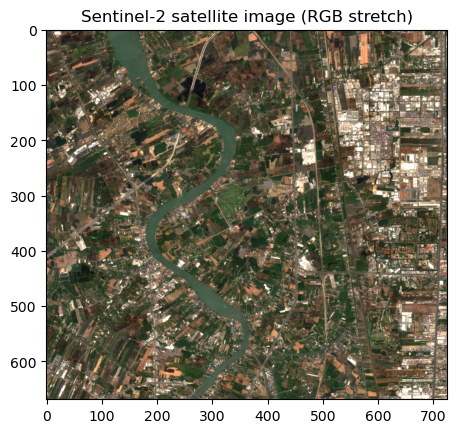

In [4]:
data_bundle = np.load("data.npz")
raw_img = data_bundle['arr_0']  # Preserve the original multispectral cube
print(f"Multispectral cube shape: {raw_img.shape}")

# Generate a stretched RGB view for context without modifying the raw data
vis_rgb = color_stretch(raw_img, [3, 2, 1], (0, 0.3))
plt.imshow(vis_rgb)
plt.title('Sentinel-2 satellite image (RGB stretch)')
plt.savefig("img.png", dpi=180, pad_inches=0, bbox_inches='tight')

In [20]:

# --- Ask for the output filename first ---
output_filename = input("Please enter the filename to save coordinates (e.g., coords.txt): ")

# --- List to store the points ---
clicked_points = []

# Load the processed image
img = cv2.imread("img.png")

# --- Check if image loaded successfully ---
if img is None:
    print("Error: Could not load image 'img.png'")
    print("Please make sure the image file is in the same directory as the script.")
    exit()

# --- Get original image dimensions ---
h, w = img.shape[:2]

# --- Set initial zoom, pan, and drag values ---
zoom_scale = 1.0  # Initial zoom level
zoom_increment = 0.1  # Zoom step
x_offset, y_offset = 0.0, 0.0  # Initial pan offset (use floats for smooth zoom)
is_dragging = False  # Flag to track if dragging
drag_start_x, drag_start_y = 0, 0  # Drag start coordinates

# --- Function to display a zoomed and panned region of the image ---
def display_zoomed_image():
    global x_offset, y_offset
    
    # Calculate new dimensions
    zoomed_w = int(w * zoom_scale)
    zoomed_h = int(h * zoom_scale)
    
    # Create resized image
    zoomed_img = cv2.resize(img, (zoomed_w, zoomed_h), interpolation=cv2.INTER_LINEAR)

    if zoom_scale >= 1.0:
        # We are zoomed in. Crop the resized image.
        
        # Calculate integer offsets for slicing and clip them to valid ranges
        x_off = int(x_offset)
        y_off = int(y_offset)
        
        # Ensure offsets are within the bounds of the zoomed image
        x_off = np.clip(x_off, 0, zoomed_w - w)
        y_off = np.clip(y_off, 0, zoomed_h - h)
        
        # Update the global float offsets (so drag/zoom math stays consistent)
        x_offset = float(x_off)
        y_offset = float(y_off)
        
        # Slice the zoomed image to get the view
        display_img = zoomed_img[y_off:y_off + h, x_off:x_off + w]
    
    else:
        # We are zoomed out. Pad the resized image to center it.
        
        # Reset offsets to 0 since panning isn't needed
        x_offset, y_offset = 0.0, 0.0 
        
        # Create a black canvas of the original window size
        display_img = np.zeros((h, w, 3), dtype=np.uint8)
        
        # Calculate top-left corner to center the small image
        start_x = (w - zoomed_w) // 2
        start_y = (h - zoomed_h) // 2
        
        # Paste the small, resized image onto the black canvas
        display_img[start_y:start_y + zoomed_h, start_x:start_x + zoomed_w] = zoomed_img

    cv2.imshow("pic", display_img)

# --- Mouse callback function to handle clicks, zoom, and pan ---
def click_event(event, x, y, flags, params):
    global zoom_scale, x_offset, y_offset, is_dragging, drag_start_x, drag_start_y

    if event == cv2.EVENT_MOUSEWHEEL:
        # --- IMPROVEMENT: Zoom at the cursor position ---
        old_zoom_scale = zoom_scale
        
        if flags > 0:  # Scroll up to zoom in
            zoom_scale = min(zoom_scale + zoom_increment, 3.0)  # Cap max zoom
        else:  # Scroll down to zoom out
            zoom_scale = max(zoom_scale - zoom_increment, 0.5)  # Min zoom limit
        
        x_offset = ((x + x_offset) * (zoom_scale / old_zoom_scale)) - x
        y_offset = ((y + y_offset) * (zoom_scale / old_zoom_scale)) - y
        
        display_zoomed_image()

    elif event == cv2.EVENT_LBUTTONDOWN:
        # Start panning
        is_dragging = True
        drag_start_x, drag_start_y = x, y
        
        # --- Calculate original image coordinates for clicking/drawing ---
        if zoom_scale >= 1.0:
            # Click when zoomed in
            orig_x = int((x + x_offset) / zoom_scale)
            orig_y = int((y + y_offset) / zoom_scale)
        else:
            # Click when zoomed out
            zoomed_w = int(w * zoom_scale)
            zoomed_h = int(h * zoom_scale)
            start_x = (w - zoomed_w) // 2
            start_y = (h - zoomed_h) // 2
            
            if start_x <= x < (start_x + zoomed_w) and start_y <= y < (start_y + zoomed_h):
                rel_x = x - start_x
                rel_y = y - start_y
                orig_x = int(rel_x / zoom_scale)
                orig_y = int(rel_y / zoom_scale)
            else:
                orig_x, orig_y = -1, -1 # Flag as invalid click (on black padding)
        
        if orig_x != -1: # Only print and draw if click was valid
            print(f"Selected coordinates: ({orig_x}, {orig_y})")
            
            # --- Store the point ---
            clicked_points.append((orig_x, orig_y))
            
            # --- Draw a smaller circle (radius 2) ---
            cv2.circle(img, (orig_x, orig_y), 2, (255, 0, 0), -1) 
            display_zoomed_image()  # Update the display with the new circle

    elif event == cv2.EVENT_MOUSEMOVE:
        # Handle panning (only when zoomed in)
        if is_dragging and zoom_scale >= 1.0:
            dx = x - drag_start_x
            dy = y - drag_start_y
            
            x_offset -= dx
            y_offset -= dy
            
            drag_start_x, drag_start_y = x, y
            display_zoomed_image()

    elif event == cv2.EVENT_LBUTTONUP:
        # Stop panning
        is_dragging = False

# --- Initialize window and set mouse callback ---
cv2.namedWindow("pic", cv2.WINDOW_NORMAL)
cv2.resizeWindow("pic", w, h) 
cv2.setMouseCallback("pic", click_event)

# Display the initial image
display_zoomed_image()

# --- Wait for 'q' key or window 'X' (close) button to quit ---
while True:
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break
        
    # Check if the 'X' (close) button on the window was clicked
    if cv2.getWindowProperty("pic", cv2.WND_PROP_VISIBLE) < 1:
        break

# --- Save the coordinates to the file ---
try:
    with open(output_filename, 'w') as f:
        
        # f.write("# X,Y coordinates\n") # <-- REMOVED THIS LINE
        
        for (x_coord, y_coord) in clicked_points:
            f.write(f"{x_coord},{y_coord}\n")
            
    print(f"Successfully saved {len(clicked_points)} points to {output_filename}")
except Exception as e:
    print(f"Error saving file: {e}")

cv2.destroyAllWindows()

Selected coordinates: (186, 52)
Selected coordinates: (198, 55)
Selected coordinates: (198, 65)
Selected coordinates: (212, 53)
Selected coordinates: (216, 54)
Selected coordinates: (212, 65)
Selected coordinates: (207, 66)
Selected coordinates: (206, 59)
Selected coordinates: (205, 57)
Selected coordinates: (210, 54)
Selected coordinates: (213, 60)
Selected coordinates: (214, 60)
Selected coordinates: (216, 63)
Selected coordinates: (222, 66)
Selected coordinates: (228, 64)
Selected coordinates: (228, 58)
Selected coordinates: (226, 55)
Selected coordinates: (220, 60)
Selected coordinates: (220, 63)
Selected coordinates: (201, 76)
Selected coordinates: (192, 62)
Selected coordinates: (189, 65)
Selected coordinates: (191, 70)
Selected coordinates: (207, 86)
Selected coordinates: (214, 86)
Selected coordinates: (216, 74)
Selected coordinates: (223, 90)
Selected coordinates: (224, 93)
Selected coordinates: (223, 94)
Selected coordinates: (220, 108)
Selected coordinates: (229, 111)
Select

In [2]:

ROI_CLASS_MAP = {
    'water_bodies.txt': 1,
    'vegetation.txt': 2,
    'barren.txt': 3,
    'road.txt': 4,
    'urban.txt': 5,
}

ROI_ROOT = Path('.')
ROI_GROUP_DIR = ROI_ROOT / 'roi_combined'


def load_roi_table(path: Path, class_id: int) -> pd.DataFrame:
    """Load a CSV-like ROI file and append the class label."""
    if not path.exists():
        raise FileNotFoundError(f"ROI file missing: {path}")
    coords = np.loadtxt(path, delimiter=',')
    coords = np.atleast_2d(coords)
    if coords.shape[1] != 2:
        raise ValueError(f"Unexpected column count in {path}. Expected 2, got {coords.shape[1]}")
    frame = pd.DataFrame(coords, columns=['x', 'y']).astype({'x': int, 'y': int})
    frame['class'] = class_id
    return frame


def assemble_roi_dataframe(files: dict, base_dir: Path) -> pd.DataFrame:
    frames = []
    for fname, class_id in files.items():
        try:
            frames.append(load_roi_table(base_dir / fname, class_id))
        except FileNotFoundError as exc:
            print(exc)
    if not frames:
        raise RuntimeError(f"No ROI files found inside {base_dir}")
    return pd.concat(frames, ignore_index=True)


roi_i_combined = assemble_roi_dataframe(ROI_CLASS_MAP, ROI_ROOT)
roi_g_combined = assemble_roi_dataframe(ROI_CLASS_MAP, ROI_GROUP_DIR)

roi_i_combined


NameError: name 'Path' is not defined

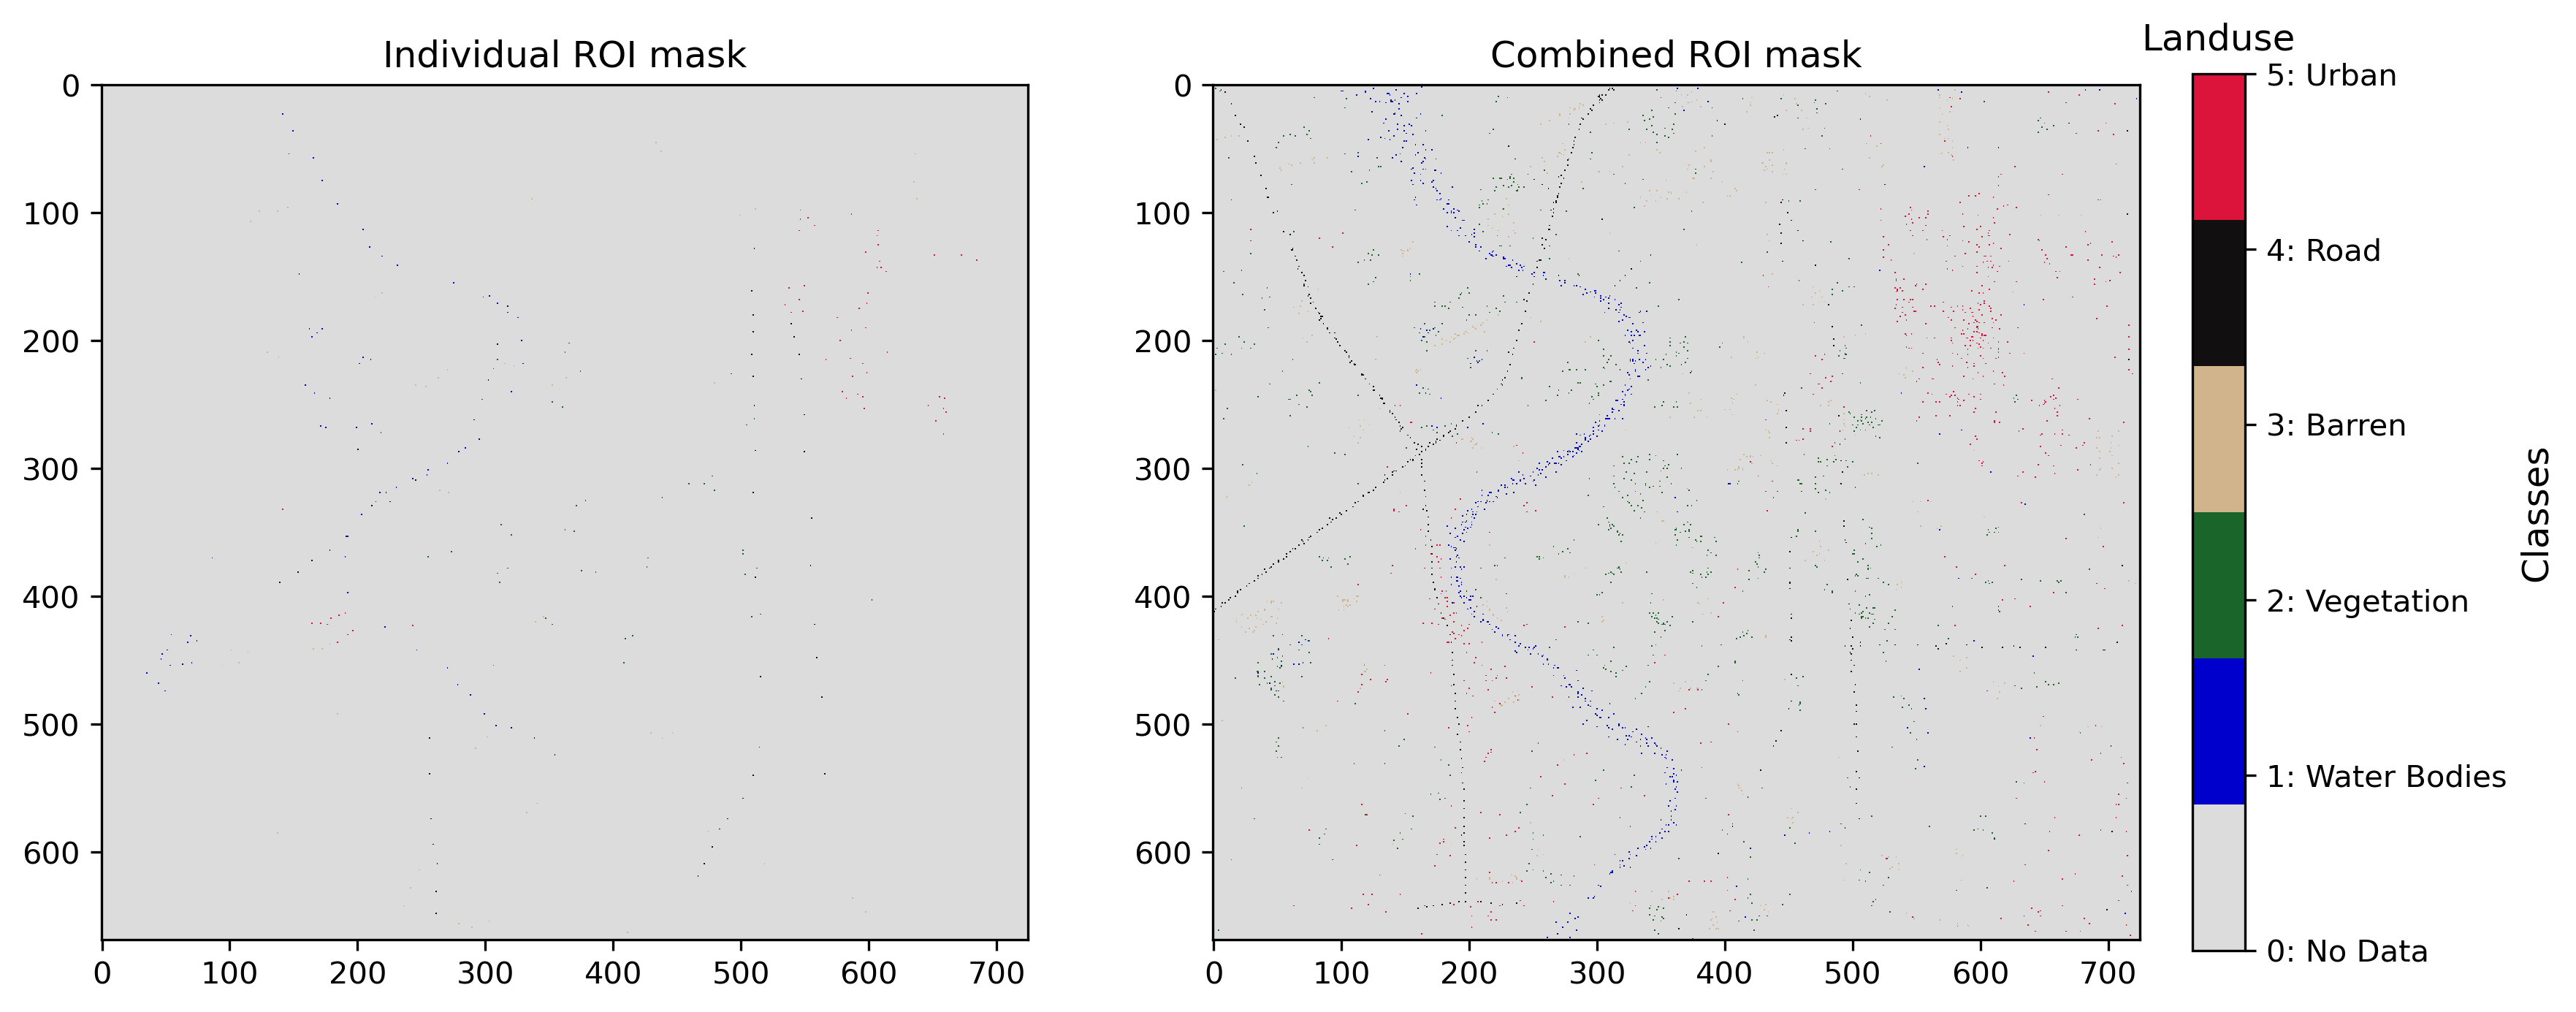

In [6]:
# Initialize empty rasters for visualising ROI coverage
height, width = raw_img.shape[:2]
roi_i = np.zeros((height, width), dtype=np.uint8)
roi_g = np.zeros((height, width), dtype=np.uint8)

# Populate ROI masks while discarding out-of-range clicks
def paint_roi(mask: np.ndarray, table: pd.DataFrame, label: str) -> None:
    x = table['x'].to_numpy()
    y = table['y'].to_numpy()
    valid = (x >= 0) & (x < width) & (y >= 0) & (y < height)
    if np.count_nonzero(~valid):
        dropped = table.loc[~valid, ['x', 'y']]
    mask[y[valid], x[valid]] = table.loc[valid, 'class'].to_numpy()


paint_roi(roi_i, roi_i_combined, 'Individual ROI')
paint_roi(roi_g, roi_g_combined, 'Grouped ROI')

# --- Visual overview ---
colors = [
    '#DCDCDC',
    '#0000CD',
    '#1A652A',
    '#D2B48C',
    "#110F0F",
    '#DC143C',
]
custom_cmap = ListedColormap(colors)
class_labels = [
    '0: No Data',
    '1: Water Bodies',
    '2: Vegetation',
    '3: Barren',
    '4: Road',
    '5: Urban',
]

fig = plt.figure(figsize=(12, 8), dpi=300)

plt.subplot(121)
plt.imshow(roi_i, cmap=custom_cmap, interpolation='none', vmin=0, vmax=5)
plt.title('Individual ROI mask')

plt.subplot(122)
img_c = plt.imshow(roi_g, cmap=custom_cmap, interpolation='none', vmin=0, vmax=5)
plt.title('Combined ROI mask')

cbar_ax = fig.add_axes([0.92, 0.245, 0.02, 0.5])
cbar = fig.colorbar(img_c, cax=cbar_ax, ticks=np.arange(0, 6))
cbar.set_label('Classes', fontsize=12)
cbar.ax.set_title('Landuse', fontsize=12, pad=8)
cbar.set_ticklabels(class_labels)

plt.show()

In [1]:
# Training the random forest model 
def train_and_classify(img, roi_df, n_estimators=500):

    # Create an empty array to store ROI labels, same dimensions as the input image
    roi = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

    # Assign each land use code to the corresponding pixel in the ROI array
    for index, row in roi_df.iterrows():
        x, y, lu_class = int(row['x']), int(row['y']), int(row['class'])
        roi[y, x] = lu_class
    
    # Prepare training data by selecting pixels with valid labels in the image
    X = img[roi > 0, :]  # Features from the image where ROI is valid
    y = roi[roi > 0]     # Labels from ROI
    
    # Train the Random Forest Classifier
    rf = RandomForestClassifier(n_estimators=n_estimators, oob_score=True, random_state=42)
    rf.fit(X, y)
    
    # Compute the out-of-bag score
    oob_score = rf.oob_score_

    # Predict classes for the entire image
    img_reshaped = img.reshape((-1, img.shape[2]))
    class_prediction = rf.predict(img_reshaped).reshape(img.shape[:2])

    return oob_score, class_prediction

# Define the ROIs to combine
rois = [river_c, agriculture_c, barren_c, urban_c, inland_water_c]

# Create and evaluate combined ROIs
results = {}
for i in range(2, 6):  # Starting from roi_2 to roi_5
    combined_roi = pd.concat(rois[:i], ignore_index=True)
    oob_score, class_prediction = train_and_classify(img, combined_roi)
    results[f'roi_{i}'] = (oob_score, class_prediction)
    print(f"OOB score for roi_{i}: {oob_score:.2f}")



NameError: name 'river_c' is not defined

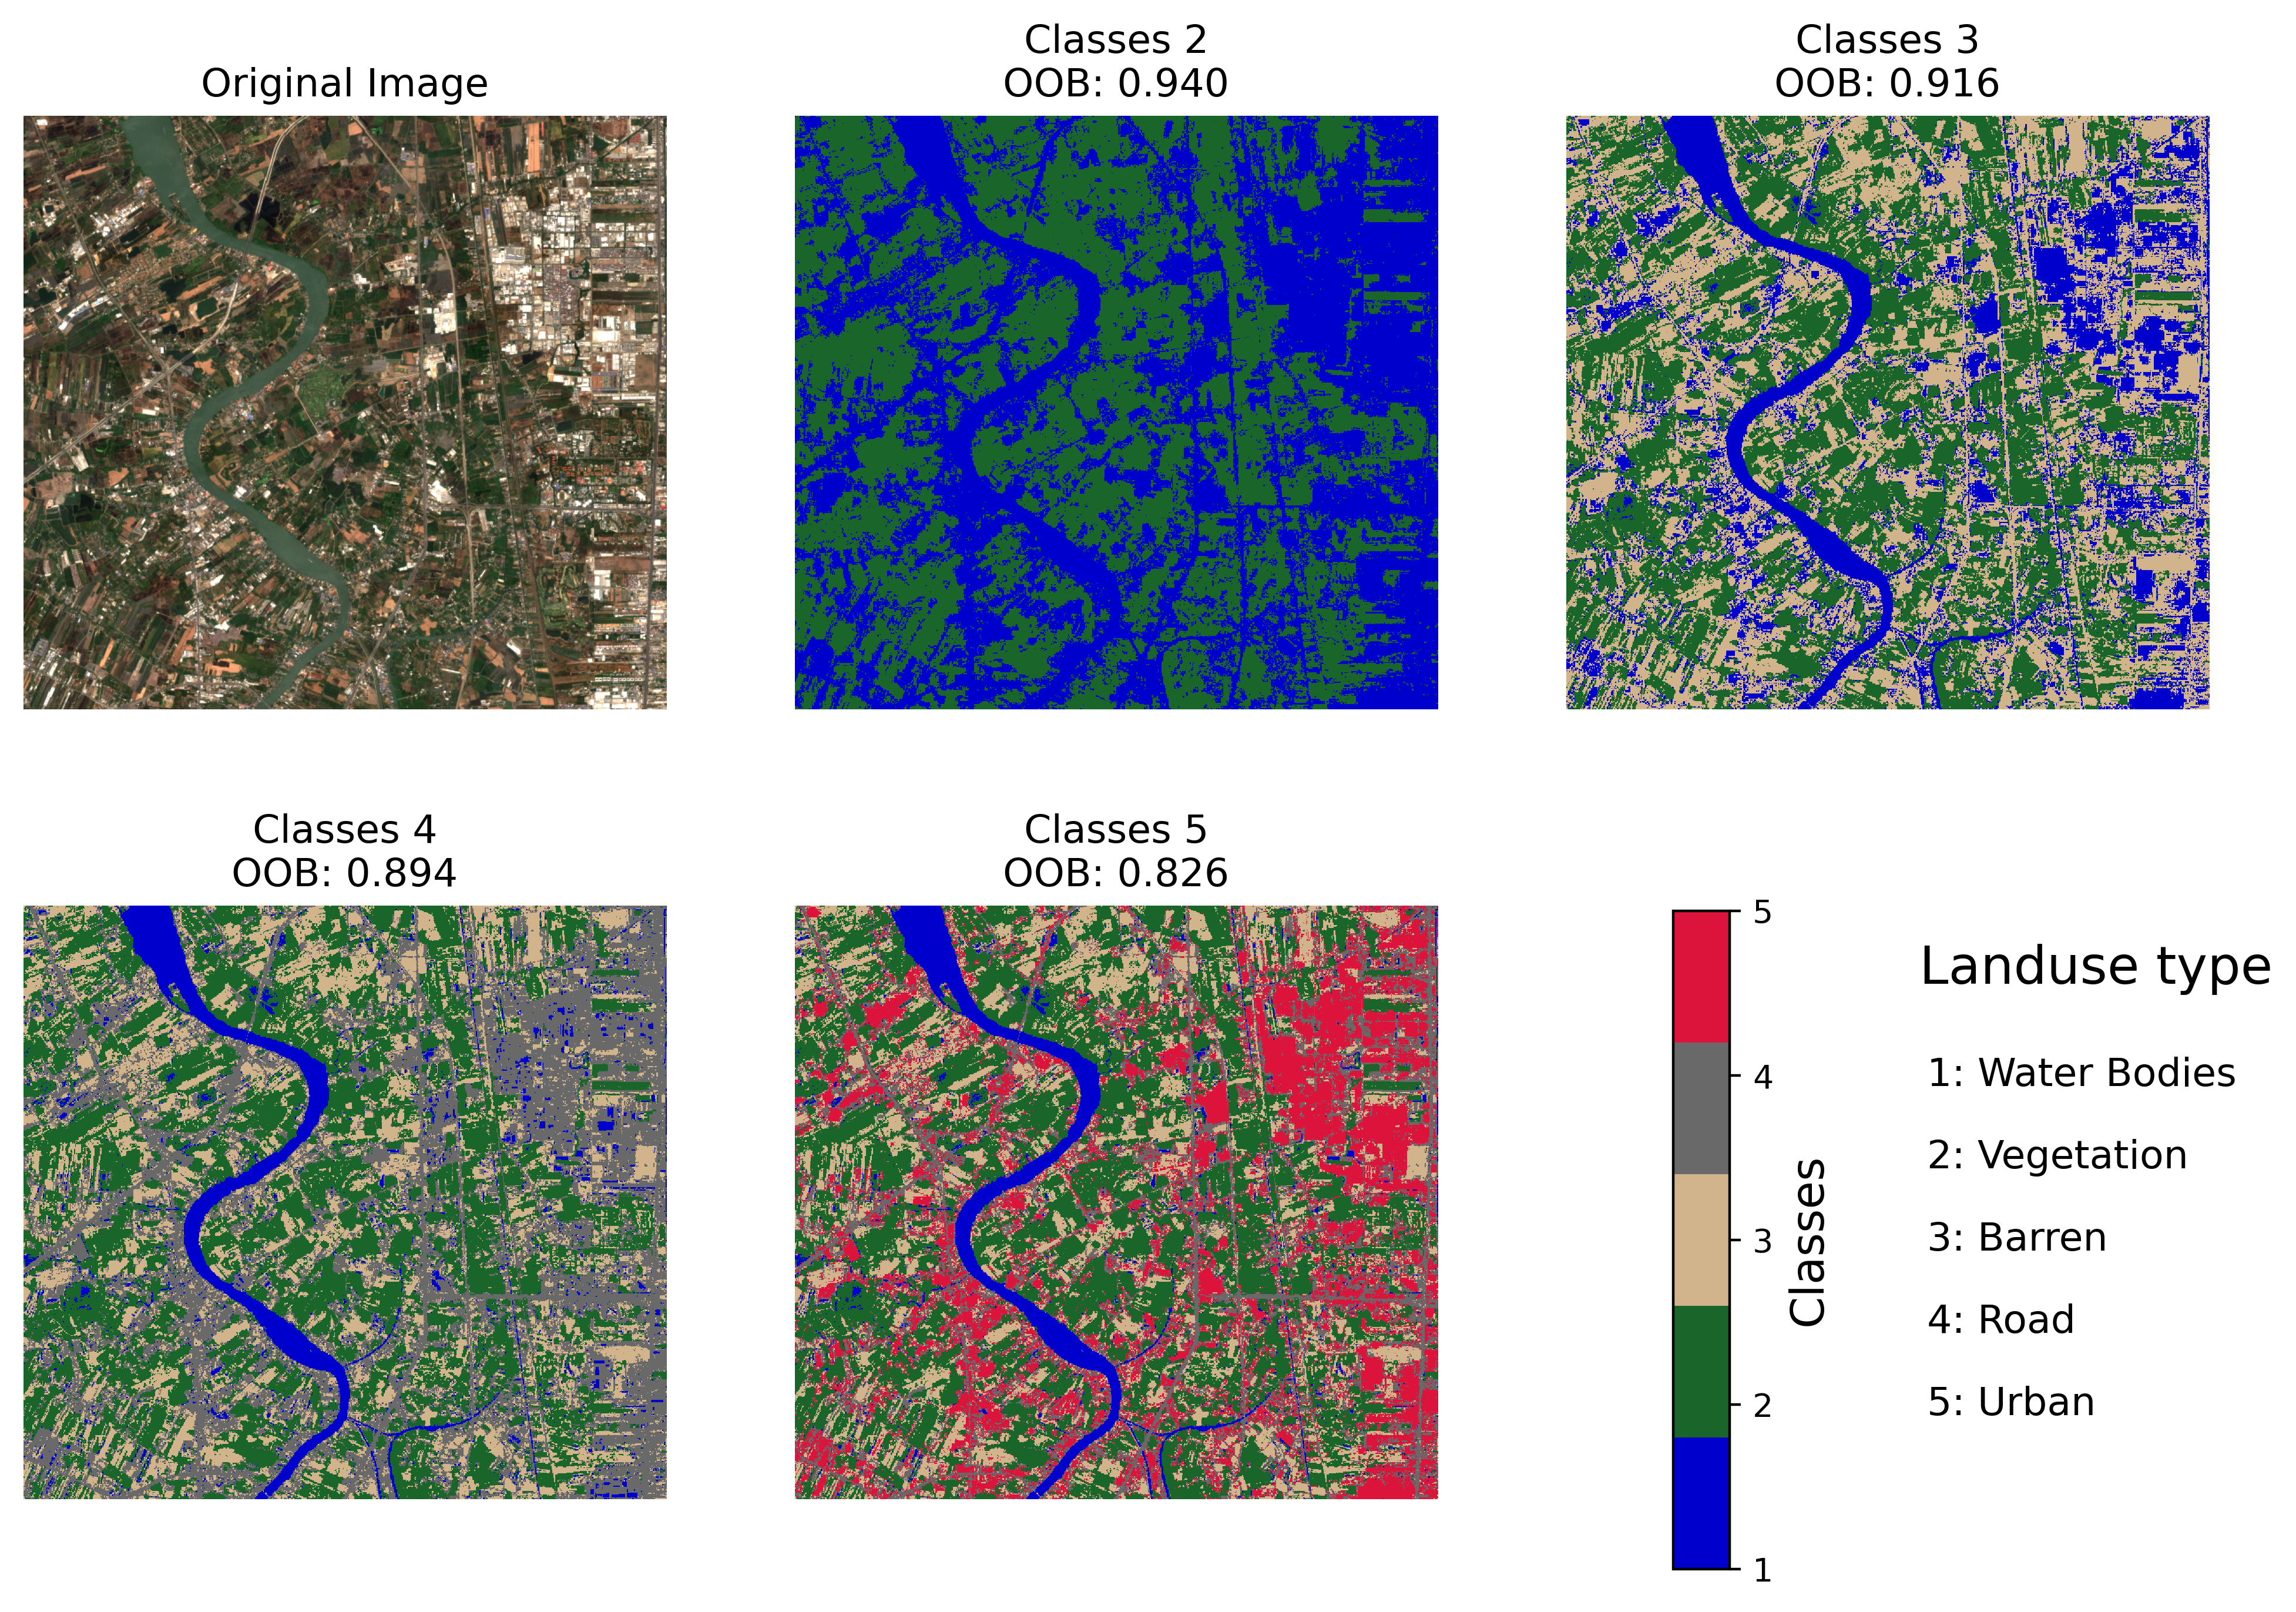

In [12]:
# Visual comparison of classification maps as class inventory grows
sorted_depths = sorted(prediction_maps.keys())
cmap_prediction = ListedColormap(colors)
oob_scores = {}
if 'progressive_summary' in locals():
    oob_scores = progressive_summary.set_index('class_count')['oob_score'].to_dict()
fig, axes = plt.subplots(2, 3, figsize=(12, 8), dpi=400)
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

# First subplot: Original image
ax1.imshow(vis_rgb)
ax1.set_title('Original Image')
ax1.axis('off')

# Helper to pull the right prediction and palette for each depth
prediction_handles = []
axis_targets = [ax2, ax3, ax4, ax5]
for depth, ax in zip(sorted_depths, axis_targets):
    cmap_depth = get_cmap(prediction_maps[depth])
    handle = ax.imshow(
        prediction_maps[depth],
        cmap=cmap_depth,
        interpolation='none',
        vmin=1,
        vmax=depth,
    )
    oob_value = oob_scores.get(depth)
    if oob_value is not None:
        title_text = f'Classes {depth}\nOOB: {oob_value:.3f}'
    else:
        title_text = f'Classes {depth}'
    ax.set_title(title_text)
    ax.axis('off')
    prediction_handles.append(handle)

# Leave the final subplot empty, matching the reference layout
ax6.axis('off')

# Build a custom color bar axis outside the subplot grid
cbar_ax = fig.add_axes([0.71, 0.09, 0.02, 0.35])
cbar = fig.colorbar(prediction_handles[-1], cax=cbar_ax, ticks=np.arange(1, 6))
cbar.set_label('Classes', fontsize=14)

# Add the legend title and class labels beside the color bar
cbar.ax.text(7.5, 4.8, 'Landuse type', fontsize=16, va='top', ha='center')
legend_labels = [
    '1: Water Bodies',
    '2: Vegetation',
    '3: Barren',
    '4: Road',
    '5: Urban',
]
legend_positions = np.linspace(4.0, 2.0, num=len(legend_labels))
for label, y_pos in zip(legend_labels, legend_positions):
    cbar.ax.text(4.5, y_pos, label, va='center', fontsize=12, ha='left')

plt.show()

In [10]:
final_depth = max(prediction_maps.keys())

final_metrics = train_random_forest(
    raw_img,
    roi_g_combined[roi_g_combined['class'].isin(CLASS_ORDER[:final_depth])],
    label_set=CLASS_ORDER[:final_depth],
)
print("Classification report for five-class model:\n")
print(final_metrics['metrics']['classification_report'])

Classification report for five-class model:

              precision    recall  f1-score   support

Water Bodies       0.96      0.83      0.89       183
  Vegetation       0.85      0.93      0.89       230
      Barren       0.73      0.82      0.77       153
        Road       0.71      0.70      0.71       121
       Urban       0.77      0.72      0.75       180

    accuracy                           0.81       867
   macro avg       0.80      0.80      0.80       867
weighted avg       0.82      0.81      0.81       867



--- 🧠 Training 5-Class Model on Individual ROIs (roi_i_combined) ---
Dropped 2 ROI points outside image bounds:
       x    y  class
191  421  669      3
192  429  669      3
Training complete.

--- 📊 Evaluation Metrics (from Individual ROIs) ---
OOB Score: 0.7021
Test Accuracy: 0.8101
Macro Precision: 0.7676
Macro Recall: 0.7790
Macro F1-Score: 0.7674

Confusion Matrix (Rows: True, Cols: Pred):
Labels: [1, 2, 3, 4, 5]
[[26  0  0  0  0]
 [ 0 11  0  0  0]
 [ 1  1  7  3  2]
 [ 0  1  5  6  1]
 [ 0  0  1  0 14]]

Classification Report:
              precision    recall  f1-score   support

Water Bodies       0.96      1.00      0.98        26
  Vegetation       0.85      1.00      0.92        11
      Barren       0.54      0.50      0.52        14
        Road       0.67      0.46      0.55        13
       Urban       0.82      0.93      0.88        15

    accuracy                           0.81        79
   macro avg       0.77      0.78      0.77        79
weighted avg       0.80     

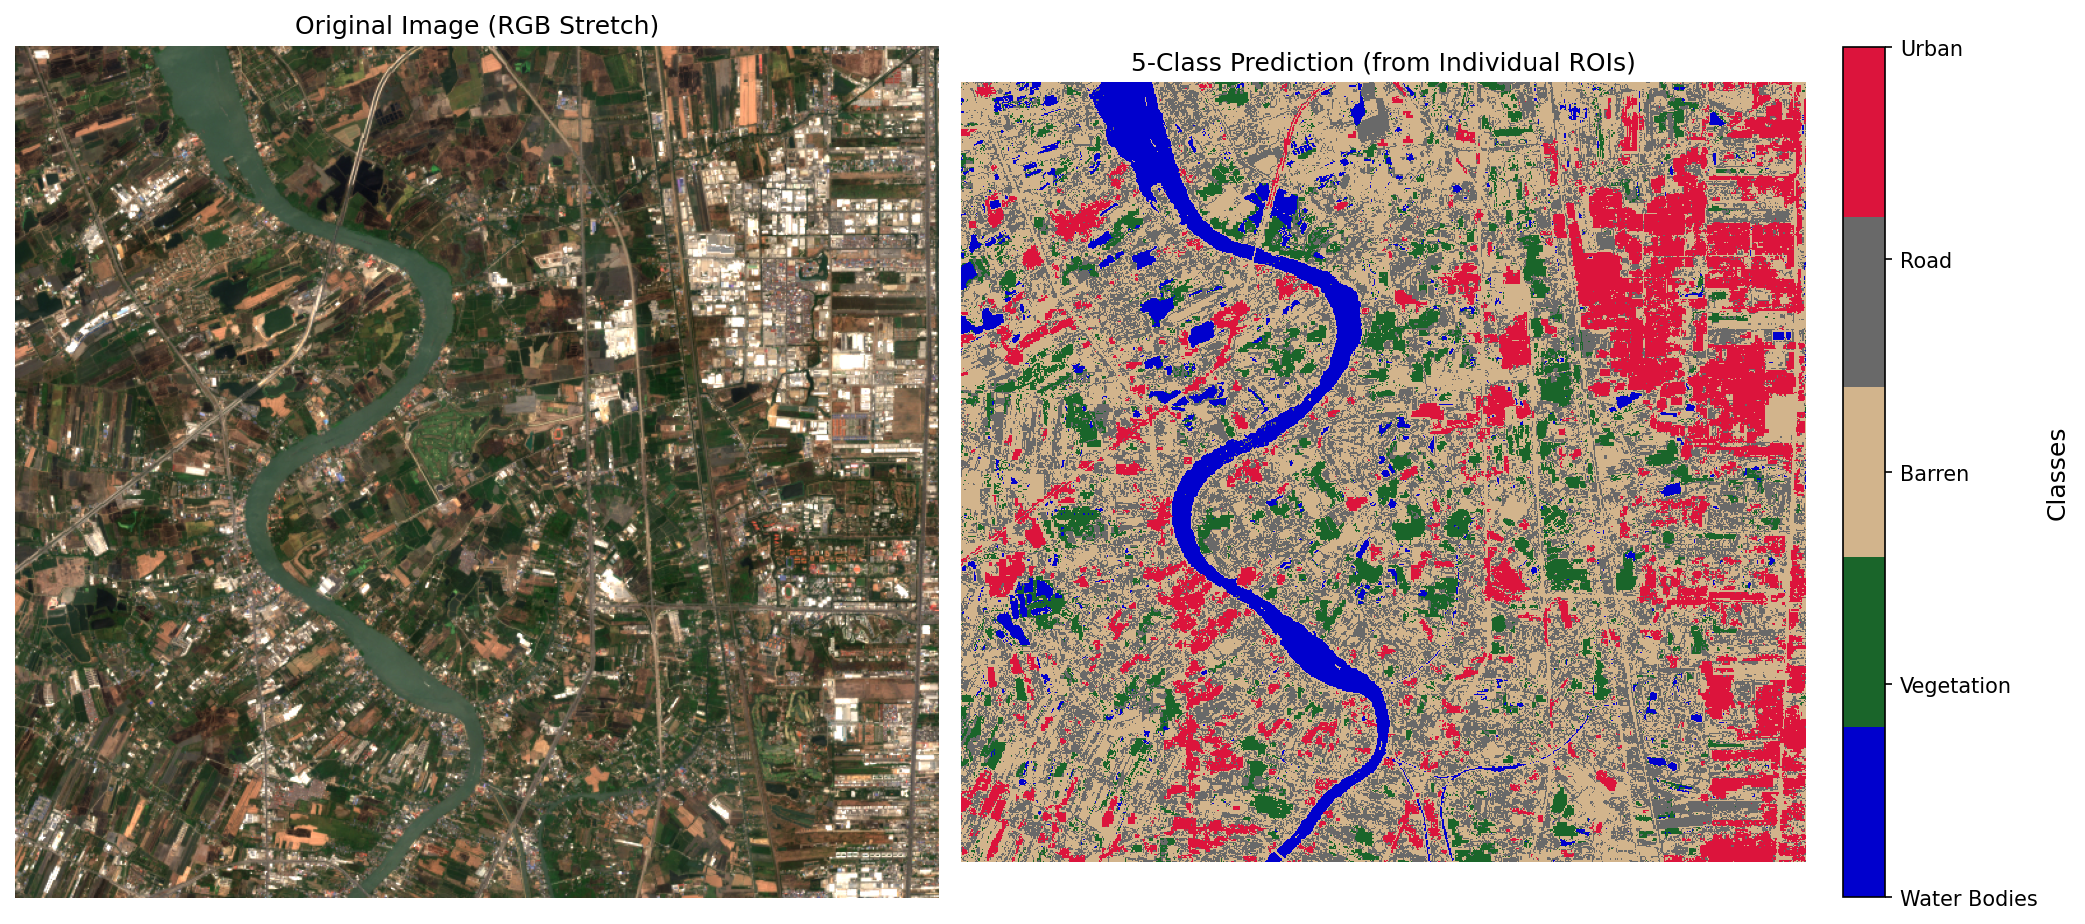

In [ ]:
("--- 🧠 Training 5-Class Model on Individual ROIs (roi_i_combined) ---")

try:
    # 1. Train the model using roi_i_combined for all 5 classes
    results_i = train_random_forest(
        raw_img,
        roi_i_combined,
        label_set=CLASS_ORDER  # Use all 5 classes [1, 2, 3, 4, 5]
    )

    metrics_i = results_i['metrics']
    prediction_i = results_i['prediction']
    print("Training complete.")

    # 2. Print all evaluation metrics
    print("\n--- 📊 Evaluation Metrics (from Individual ROIs) ---")
    print(f"OOB Score: {metrics_i['oob_score']:.4f}")
    print(f"Test Accuracy: {metrics_i['test_accuracy']:.4f}")
    print(f"Macro Precision: {metrics_i['macro_precision']:.4f}")
    print(f"Macro Recall: {metrics_i['macro_recall']:.4f}")
    print(f"Macro F1-Score: {metrics_i['macro_f1']:.4f}")

    print("\nConfusion Matrix (Rows: True, Cols: Pred):")
    print(f"Labels: {CLASS_ORDER}")
    print(metrics_i['confusion_matrix'])

    print("\nClassification Report:")
    print(metrics_i['classification_report'])

    # 3. Plot the resulting map
    print("\n--- 🗺️ Generating Classification Map (from Individual ROIs) ---")

    cmap_i = get_cmap(prediction_i)
    fig, axes = plt.subplots(1, 2, figsize=(14, 7), dpi=150)

    axes[0].imshow(vis_rgb)
    axes[0].set_title('Original Image (RGB Stretch)')
    axes[0].axis('off')

    img_c = axes[1].imshow(
        prediction_i,
        cmap=cmap_i,
        interpolation='none',
        vmin=1,
        vmax=5,
    )
    axes[1].set_title('5-Class Prediction (from Individual ROIs)')
    axes[1].axis('off')

    cbar = fig.colorbar(img_c, ax=axes[1], ticks=np.arange(1, 6), fraction=0.046, pad=0.04)
    cbar.set_label('Classes', fontsize=12)
    cbar.ax.set_yticklabels([CLASS_LABELS[i] for i in CLASS_ORDER])

    plt.tight_layout()
    plt.show()

except (ValueError, RuntimeError) as e:
    print(f"\n❌ Error during Individual ROI processing: {e}")
    print("This can happen if your individual ROI files (e.g., 'water_bodies.txt') don't contain enough samples for at least two different classes.")

In [ ]:
# Visual comparison of classification maps as class inventory grows
sorted_depths = sorted(prediction_maps.keys())
cmap_prediction = ListedColormap(colors)
oob_scores = {}
if 'progressive_summary' in locals():
    oob_scores = progressive_summary.set_index('class_count')['oob_score'].to_dict()
fig, axes = plt.subplots(2, 3, figsize=(12, 8), dpi=400)
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

# First subplot: Original image
ax1.imshow(vis_rgb)
ax1.set_title('Original Image')
ax1.axis('off')

# Helper to pull the right prediction and palette for each depth
prediction_handles = []
axis_targets = [ax2, ax3, ax4, ax5]
for depth, ax in zip(sorted_depths, axis_targets):
    cmap_depth = get_cmap(prediction_maps[depth])
    handle = ax.imshow(
        prediction_maps[depth],
        cmap=cmap_depth,
        interpolation='none',
        vmin=1,
        vmax=depth,
    )
    oob_value = oob_scores.get(depth)
    if oob_value is not None:
        title_text = f'Classes {depth}\nOOB: {oob_value:.3f}'
    else:
        title_text = f'Classes {depth}'
    ax.set_title(title_text)
    ax.axis('off')
    prediction_handles.append(handle)

# Leave the final subplot empty, matching the reference layout
ax6.axis('off')

# Build a custom color bar axis outside the subplot grid
cbar_ax = fig.add_axes([0.71, 0.09, 0.02, 0.35])
cbar = fig.colorbar(prediction_handles[-1], cax=cbar_ax, ticks=np.arange(1, 6))
cbar.set_label('Classes', fontsize=14)

# Add the legend title and class labels beside the color bar
cbar.ax.text(7.5, 4.8, 'Landuse type', fontsize=16, va='top', ha='center')
legend_labels = [
    '1: Water Bodies',
    '2: Vegetation',
    '3: Barren',
    '4: Road',
    '5: Urban',
]
legend_positions = np.linspace(4.0, 2.0, num=len(legend_labels))
for label, y_pos in zip(legend_labels, legend_positions):
    cbar.ax.text(4.5, y_pos, label, va='center', fontsize=12, ha='left')

plt.show()

In [ ]:
import opencv